In [332]:
library ("igraph")
library('igraph')
library('Matrix')
library('pracma')
library('plyr')

## 3 PageRank
#### a) 
We are going to create a directed random network with 1000 nodes, using the preferential attachment model. Note that in a directed preferential attachment network,
the out-degree of every node is m, while the in-degrees follow a power law distribution.
One problem of performing random walk in such a network is that, the very first
node will have no outbounding edges, and be a “black hole” which a random walker
can never “escape” from. To address that, let’s generate another 1000-node random
network with preferential attachment model, and merge the two networks by adding
the edges of the second graph to the first graph with a shuffling of the indices of the
nodes. For example, <img src="number3a.png">
Create such a network using m = 4. Measure the probability that the walker visits
each node. Is this probability related to the degree of the nodes?

In [333]:
g1 <- sample_pa(1000, m=4) #first graph
g2 <- sample_pa(1000, m=4) #second graph

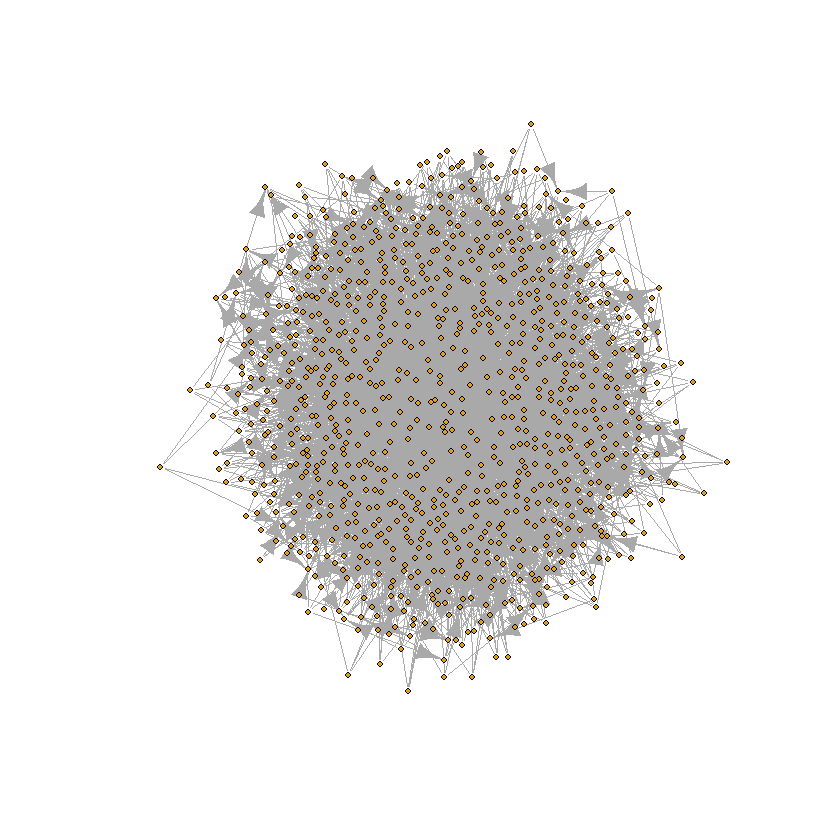

[1] TRUE

[1] 7.98

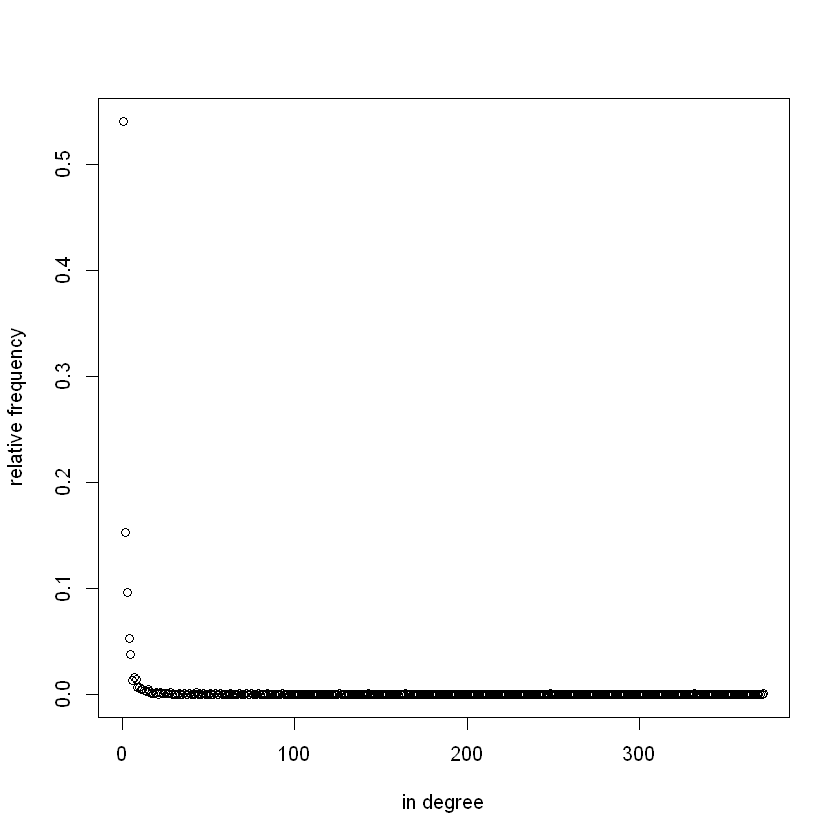

In [334]:
# lets see what our graph looks like
g1 <- set.graph.attribute(g1, "layout", layout.fruchterman.reingold(g1))
plot(g1, vertex.label="", vertex.size=2)
plot(degree.distribution(g1, mode="in"), xlab="in degree", ylab="relative frequency")
is.connected(g1)
mean(degree(g1))

In [335]:
g2_edgelist <- as_edgelist(g2)  # |E| by 2 matrix
g2_shuffle <- permute(g2, sample(vcount(g2)))
g2_shuffle_edgelist <- as_edgelist(g2_shuffle)
#add edges takes a 2|E| length vector of edges as opposed to a |E| by 2 matrix 
g <- add_edges(g1, as.vector(t(g2_shuffle_edgelist)))  

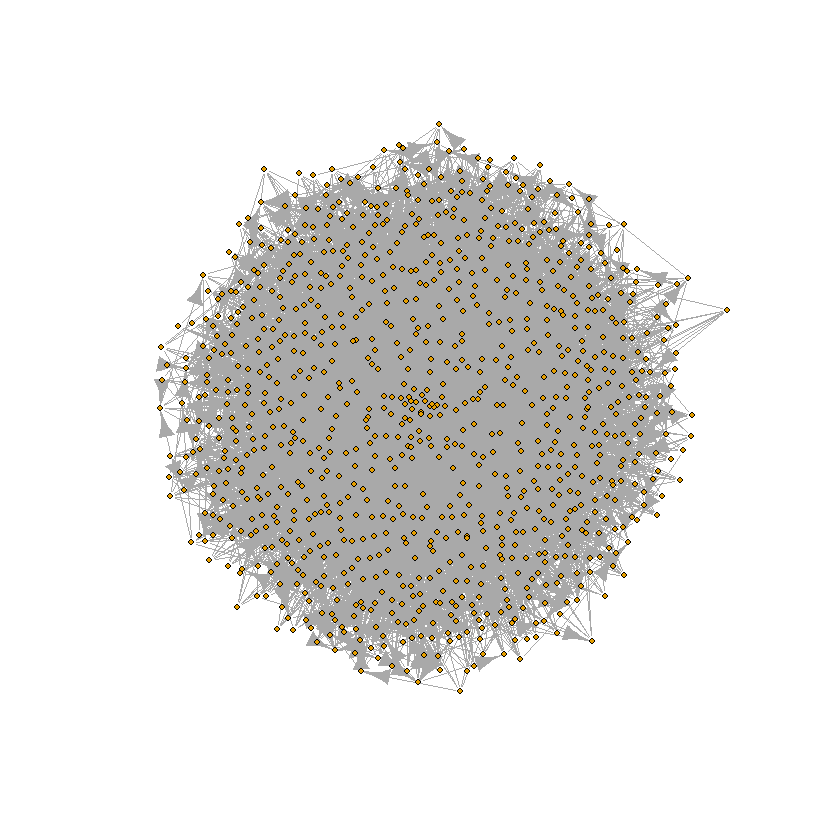

[1] TRUE

[1] 15.96

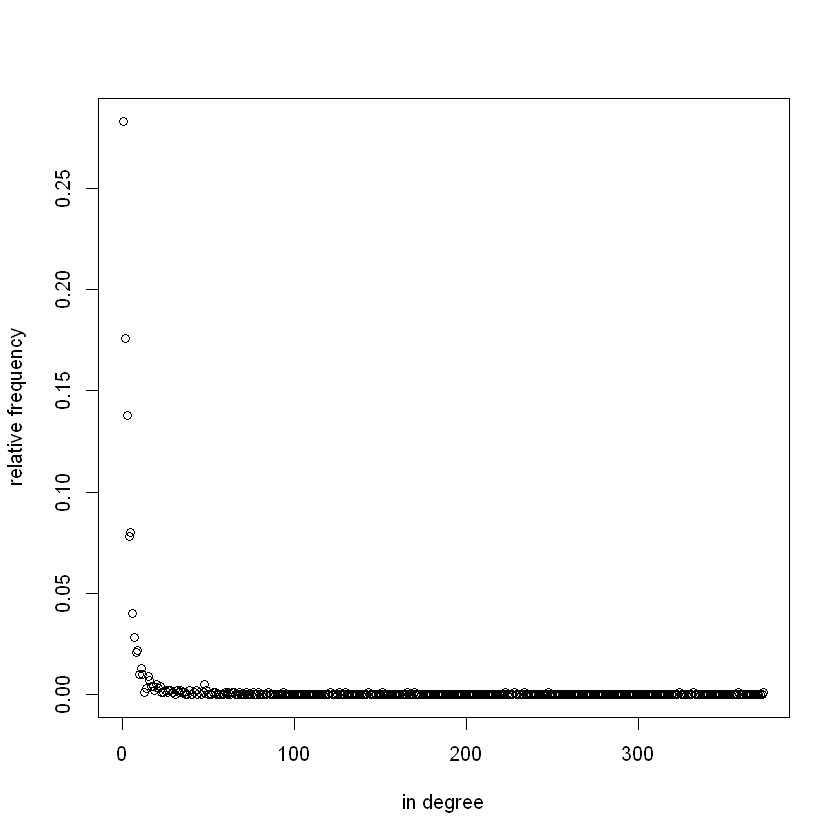

In [336]:
#new graph constructed as specified in spec
g <- set.graph.attribute(g, "layout", layout.fruchterman.reingold(g))
plot(g, vertex.label="", vertex.size=2)
plot(degree.distribution(g, mode="in"), xlab="in degree", ylab="relative frequency")
is.connected(g)
mean(degree(g))

In [337]:
build_transition_matrix = function (g){
    vs = V(g)
    n = vcount(g)
    adj_matrix = as_adjacency_matrix(g)
    adj_matrix[diag(rowSums(adj_matrix) == 0)] = 1 
    r_sum = rowSums(adj_matrix)
    diag_matrix = (diag(1/r_sum))
    transition_matrix = diag_matrix %*% adj_matrix  # normalize to get probabilities
  
  return(transition_matrix)
}

In [338]:
rand_walk = function(g, num_steps, start_node, transition_matrix, alpha=NULL, teleport_prob=NULL){    
    if (is.null(alpha))
        alpha = 0
    
    if (alpha != 0  && (is.null(teleport_prob)))
        teleport_prob = rep(1/vcount(g), vcount(g))
    
    node = start_node
    walk = rep(0,num_steps)
    for(i in 1:num_steps){
        trans_prob = transition_matrix[node,]
        node = sample(1:vcount(g), 1, prob=trans_prob)
        if (alpha != 0){
            node2 = sample(1:vcount(g), 1, prob=teleport_prob)
            random = sample(1:100,1) / 100
            if (random < alpha)
                node = node2
        }
        walk[i] = node
    }
    return(walk)
}

In [339]:
run_rand_walk_trials = function(num_steps, num_trials, alpha=NULL, teleport_prob=NULL){
    
    cumulative_df = data.frame(table(rep(seq(vcount(g)), 1))-1)
    transition_matrix = build_transition_matrix(g)
    for (i in 1:num_trials){
        start_node = sample(vcount(g), 1)
        walk = rand_walk(g, start_node, num_steps, transition_matrix, alpha, teleport_prob)
        temp_df = data.frame(table(rep(seq(vcount(g)), 1))-1)
        walk_results = data.frame(table(walk))
        temp_df = merge(temp_df,walk_results, by.x="Var1", by.y="walk", all.x=TRUE)
        temp_df[is.na(temp_df)] <- 0
        cumulative_df$Freq = (as.numeric(cumulative_df$Freq) + as.numeric(temp_df$Freq.y))
    }

    cumulative_df$Freq = cumulative_df$Freq / (num_steps * num_trials)
    return(cumulative_df$Freq)
}

#### a) 
Is this probability related to the degree of the nodes?

In [340]:
pr<-run_rand_walk_trials(500, 100)
deg<-degree(g,mode="in")
deg_normalized <-(deg / sum(deg))

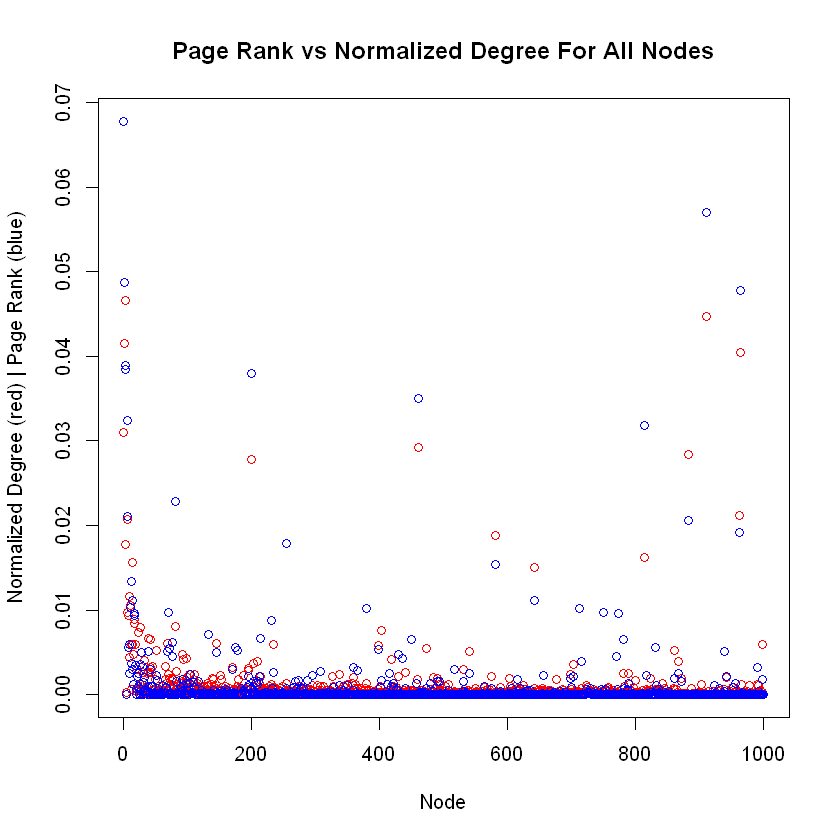

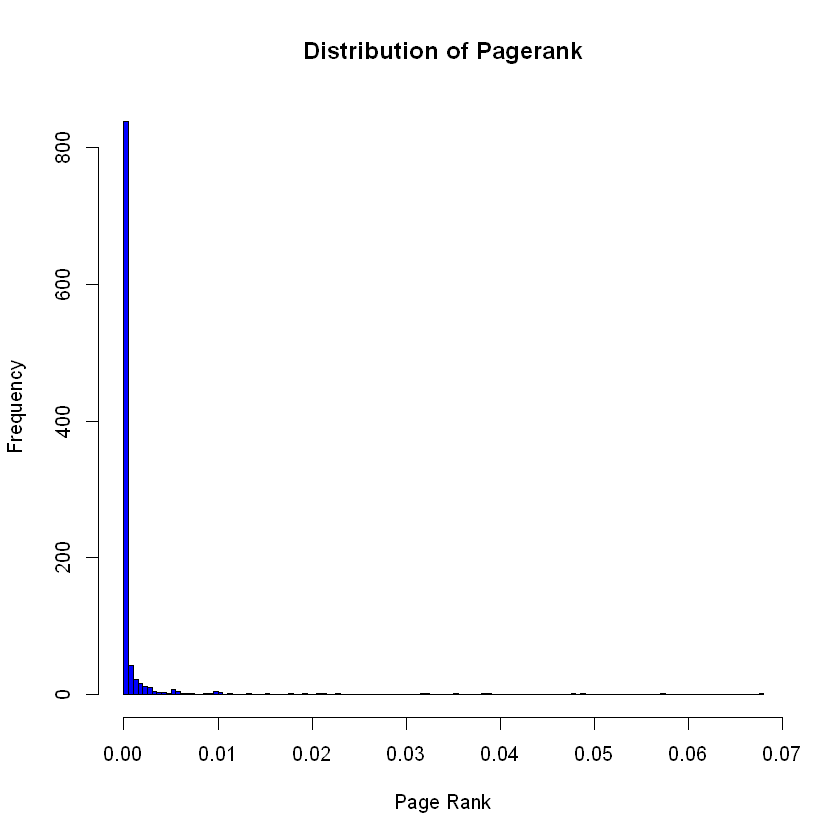

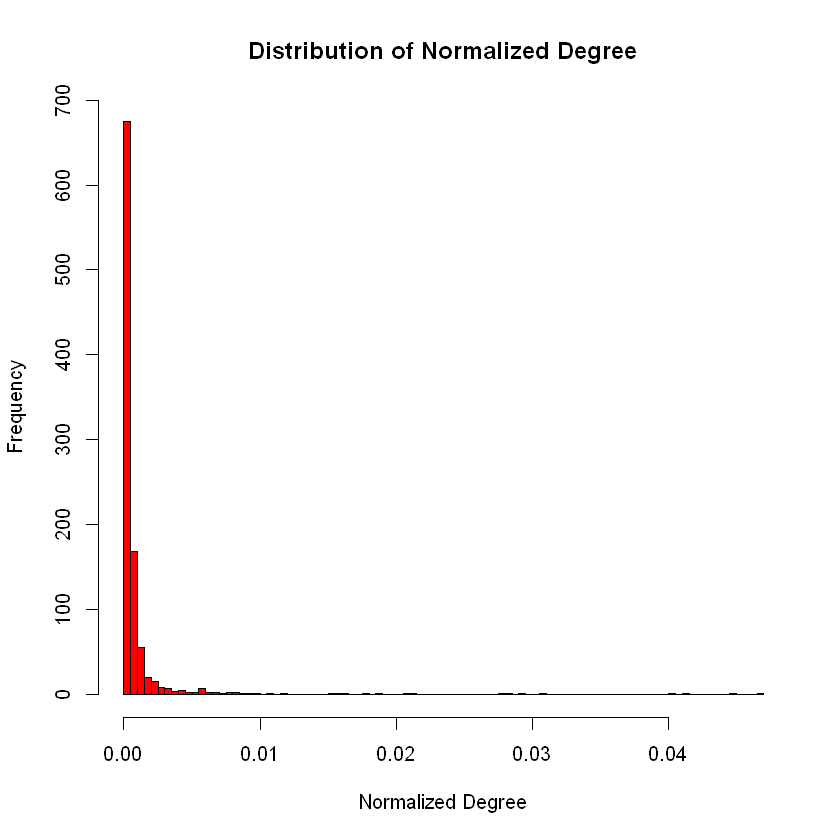

In [341]:
max_deg = max(deg_normalized)
max_y = max(max(pr), max_deg)
plot(deg_normalized, col="red",ylim=c(0,max_y), main='Page Rank vs Normalized Degree For All Nodes', ylab='Normalized Degree (red) | Page Rank (blue)', xlab='Node')
points(pr, col="blue")
hist(pr, breaks=100, col='blue', main='Distribution of Pagerank', xlab='Page Rank')
hist(deg_normalized, breaks=100, col='red', main='Distribution of Normalized Degree', xlab='Normalized Degree')

#### ans:
From the graph of page rank vs normalized degree above the probability that a walker visits a node is correlated for many nodes and is somewhat related. The normalized degree is a good comparison as the sum of all degrees is now 1 so that we can make a one to one value comparison with page rank. A lot of early nodes built through the PA model have high degree and seem to also have high page rank. For the most part it seems that most nodes who have small degrees also have small page ranks. However, it is also clear that they are not the same as we can see many examples of nodes with large differences between page rank and degree. Nodes with relatively high degree also tend to have higher page ranks but their values are still somewhat different. Generally high degree nodes seem to have an even higher PageRank while low degree nodes have an even lower PageRank. From the subsequent graphs on the distribution of page rank and degree values we see that the distribution of these two attributes of nodes seem to highly concentrated towards 0. However, we see that page rank values are even more concentrated towards 0. 

#### b) 
In all previous questions, we didn’t have any teleportation. Now, we use a teleportation probability of α = 0.15. By performing random walks on the network created
in 3(a), measure the probability that the walker visits each node. Is this probability
related to the degree of the node?

In [ ]:
pr_alpha <-run_rand_walk_trials(500, 100, 0.15)

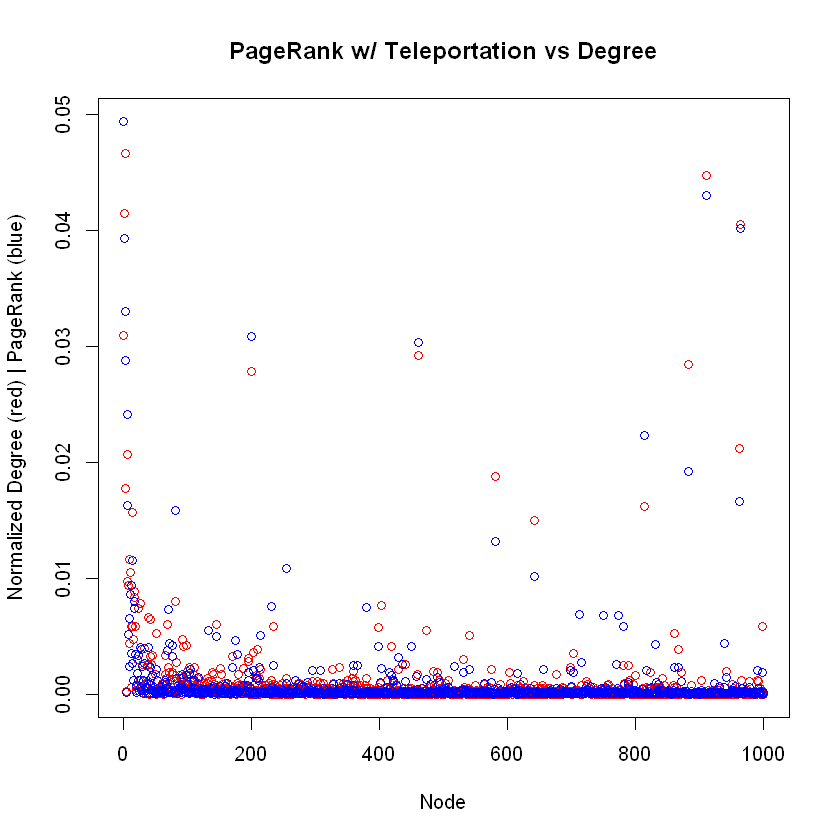

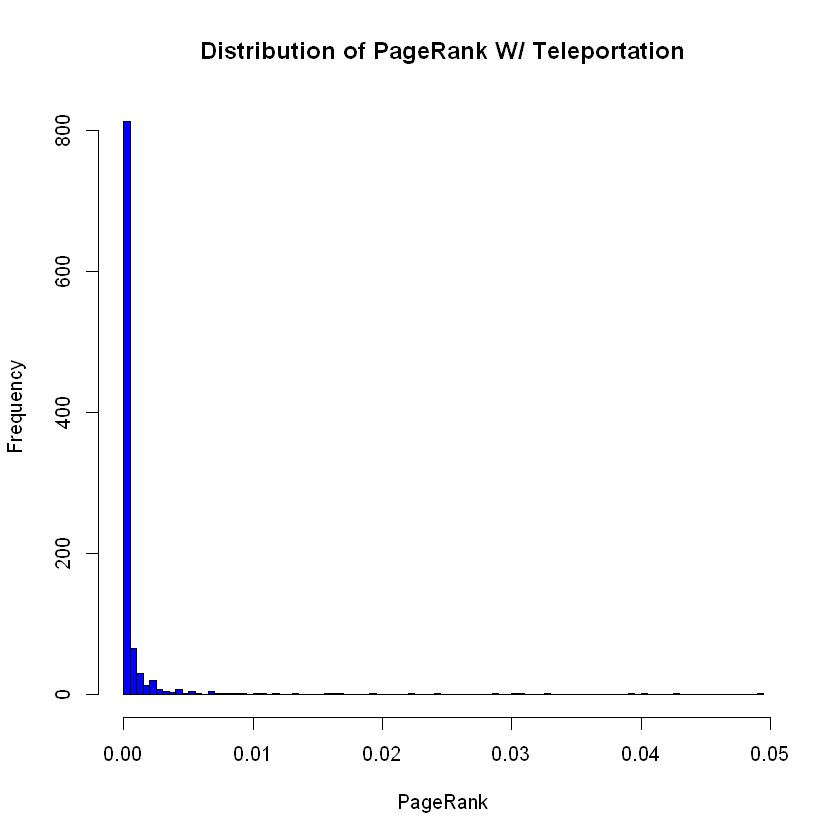

In [346]:
max_y = max(max(pr_alpha, max_deg))
plot(deg_normalized, col="red", ylim=c(0,max_y), main='PageRank w/ Teleportation vs Degree', ylab='Normalized Degree (red) | PageRank (blue)', xlab='Node')
points(pr_alpha, col="blue")
hist(pr_alpha, breaks=100, col='blue', main='Distribution of PageRank W/ Teleportation', xlab='PageRank')


#### ans:
From the graphs below it appears that the situation is like the relationship in part a) where degree and probability are similar for the most part but there also multiple examples where the degree and probability for a given node is not really related. However, we do notice that for low degree nodes the page rank is closer in value and high degree nodes to not have relatively even higher page rank as part a). This makes sense as adding a teleportation probability improves the page rank of lower page rank nodes in part a) and deflates the page rank of higher page rank nodes as it acts as regularization. Other than this the similarity to a) also makes sense as the probability of jumping to specific node if we decide to teleport is equal for all nodes so the relativity of page rank values should not be greatly affected.

## 4 Personalized PageRank

#### a)
Suppose you have your own notion of importance. Your interest in a node is proportional to the node’s PageRank, because you totally rely upon Google to decide which website to visit (assume that these nodes represent websites). Again, use random walk on network generated in question 3 to simulate this personalized PageRank. Here the teleportation probability to each node is proportional to its PageRank (as opposed to the regular PageRank, where at teleportation, the chance of visiting all nodes are the same and equal to 1/N). Again, let the teleportation probability be equal to α = 0.15. Compare the results with 3(a).


In [ ]:
personalized_dist = pr
pr_alpha_personalized <-run_rand_walk_trials(500, 100, 0.15, personalized_dist)

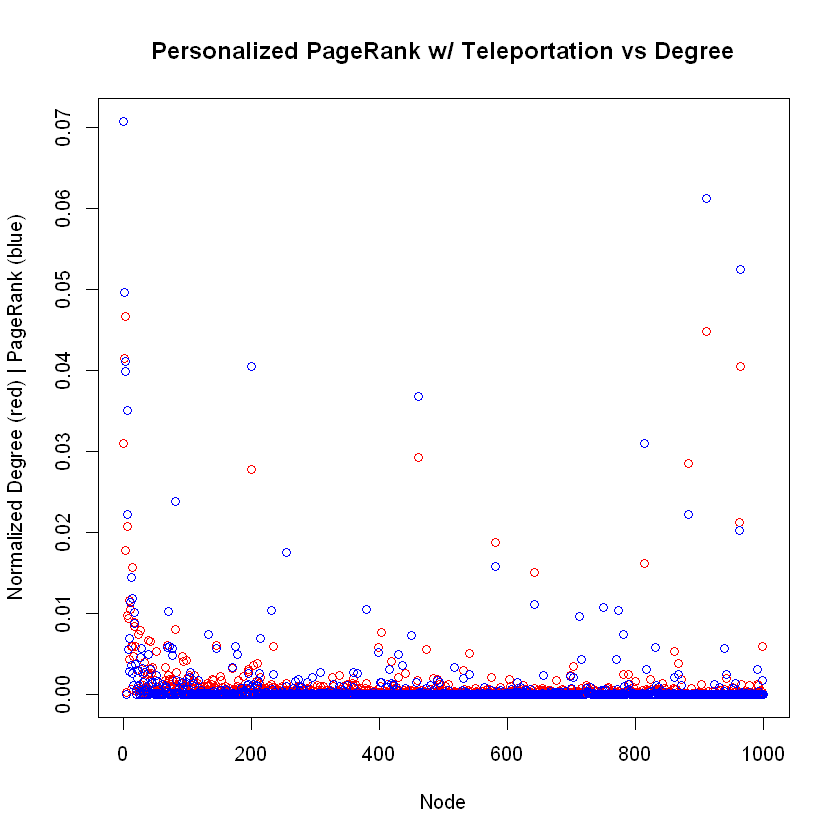

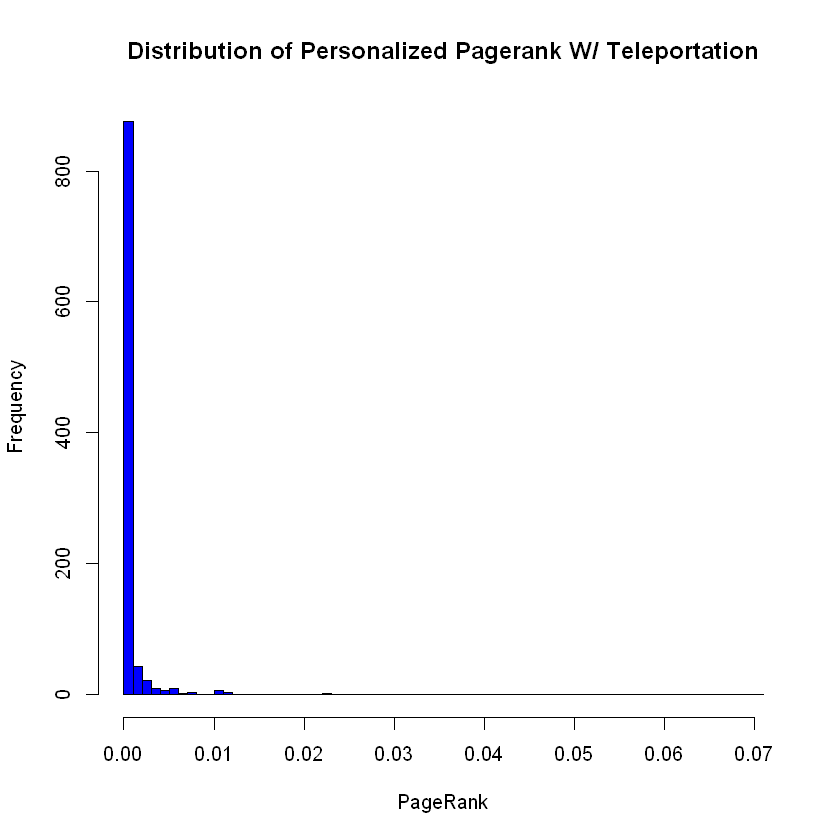

In [345]:
max_y = max(max(pr_alpha_personalized), max_deg)
plot(deg_normalized, col="red", ylim=c(0,max_y), main='Personalized PageRank w/ Teleportation vs Degree', ylab='Normalized Degree (red) | PageRank (blue)', xlab='Node')
points(pr_alpha_personalized, col="blue")
hist(pr_alpha_personalized, breaks=100, col='blue', main='Distribution of Personalized Pagerank W/ Teleportation', xlab='PageRank')

#### ans:
The results are very similar to 3a). This makes sense as a personalized pagerank where the probability of jumping to a node when teleporting is proportional to the nodes' pagerank is essentially pagerank without teleportation but just with an added randomness in teleportation. 

#### b)
Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the PageRank values affected?


5
20


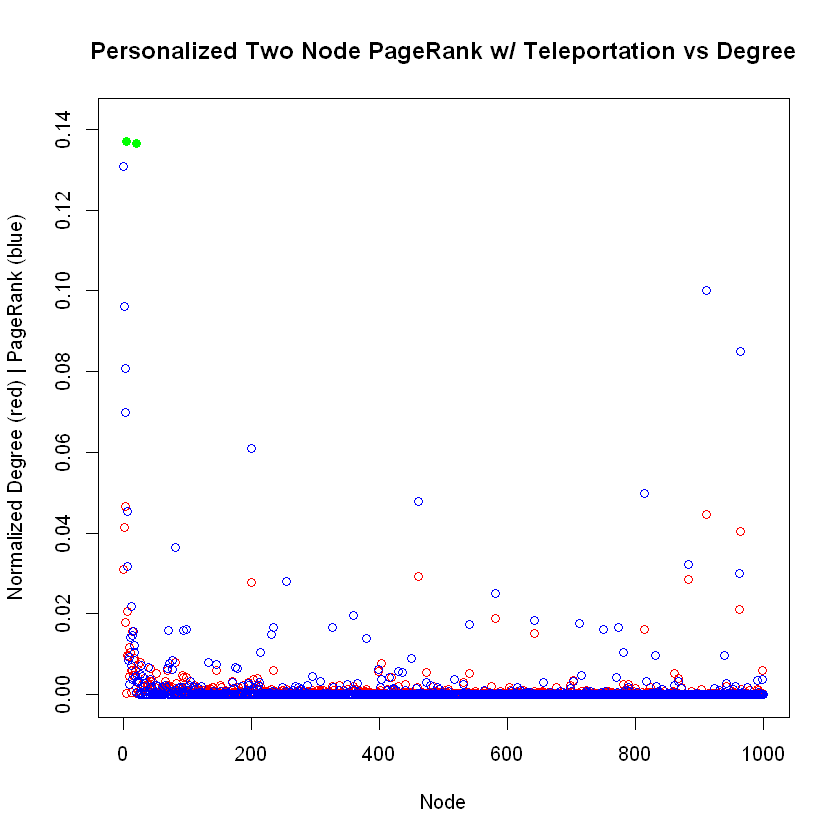

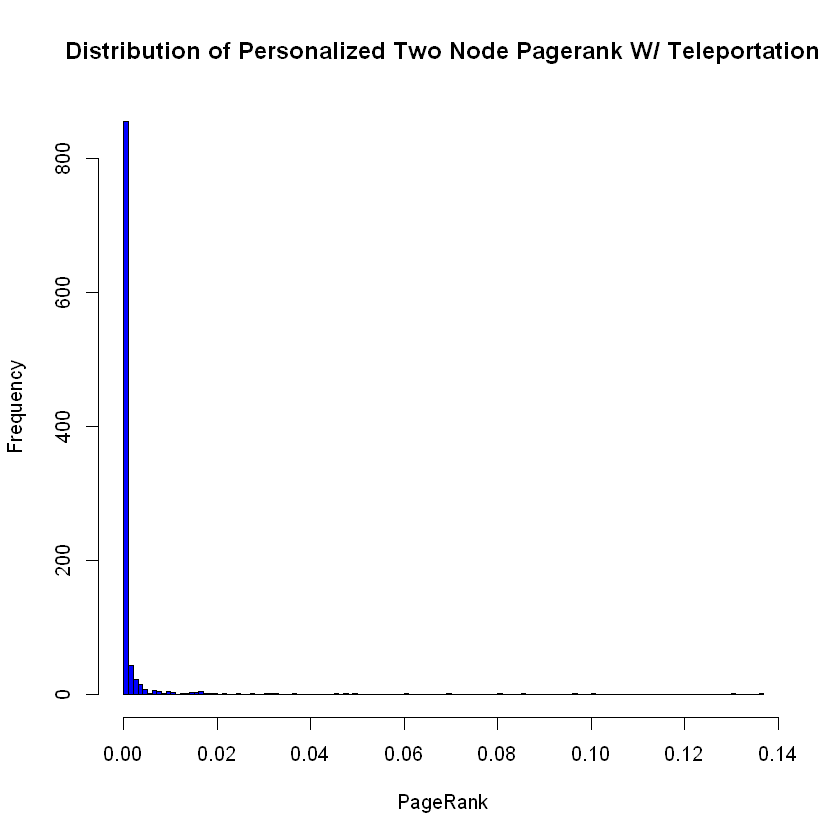

In [344]:
x <- 1 : vcount(g)
pr_sorted = sort(pr, decreasing=TRUE)
median1 = pr_sorted[500]
median2 = pr_sorted[501]
medians = which(median1 == pr | median2 == pr)
ind1 = medians[1]
ind2 = medians[2]
personalized_distribution = c(rep(0, vcount(g)))
personalized_distribution[ind1] = 0.5
personalized_distribution[ind2] = 0.5
message(ind1)
message(ind2)
pr_personalized_two_nodes <- run_rand_walk_trials(250, 100, 0.15, personalized_distribution)
max_y = max(max(pr_personalized_two_nodes), max_deg)
plot(x, deg_normalized, ylim=c(0, max_y + 0.005), col='red', main='Personalized Two Node PageRank w/ Teleportation vs Degree', ylab='Normalized Degree (red) | PageRank (blue)', xlab='Node')
points(x, pr_personalized_two_nodes, ylim=c(0, max_y + 0.005), col=ifelse((x==ind1 | x==ind2), "green", "blue"), pch=ifelse((x==ind1 | x==ind2), 19,1))
hist(pr_personalized_two_nodes, breaks=100, col='blue', main='Distribution of Personalized Two Node Pagerank W/ Teleportation', xlab='PageRank')

#### ans:
The pagerank of the non-median nodes seem to be basically the same as 3a) and 4a) except now the page rank of the median nodes are now much higher than before and even higher than all the other nodes. This makes sense as any time we are teleporting with a probability of 0.15 we are always going to land on one of these two nodes. Likewise the pagerank of these two nodes are very close to each other as their original page rank values were already very close and we had equal probablity of teleporting to either of these two nodes.  

#### c) 
More or less, 4(b) is what happens in the real world, in that a user browsing the web only teleports to a set of trusted web pages. However, this is against the assumption of normal PageRank, where we assume that people’s interest in all nodes are the same. Can you take into account the effect of this self-reinforcement and adjust the PageRank equation?